In [1]:
%load_ext autoreload
%autoreload 2

import copy
import random
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

from leaf_disease.datasets.dataset import LeafImageDataset, LeafImageDataModule, split_data

In [2]:
input_path = Path("input")
image_path = Path("input/train_images/")

In [3]:
dfx = pd.read_csv("input/train.csv")
dfx.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Label description 

```json
{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}
```

In [4]:
dfx.label.value_counts(normalize=False)

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [5]:
train, valid = split_data(dfx)
print(f"{train.shape=}")
print(f"{valid.shape=}")

train.shape=(17117, 2)
valid.shape=(4280, 2)


Proportion of the target in the splits

In [6]:
vc_1 = train.label.value_counts(normalize=True).to_frame(name="train")
vc_2 = valid.label.value_counts(normalize=True).to_frame(name="valid")
pd.concat([vc_1, vc_2], axis=1)

train     valid
label                    
3      0.614944  0.614953
4      0.120407  0.120561
2      0.111527  0.111449
1      0.102296  0.102336
0      0.050827  0.050701

In [7]:
vc_1 = train.label.value_counts(normalize=True).to_frame(name="train")
vc_2 = valid.label.value_counts(normalize=True).to_frame(name="valid")
pd.concat([vc_1, vc_2], axis=1)

train     valid
label                    
3      0.614944  0.614953
4      0.120407  0.120561
2      0.111527  0.111449
1      0.102296  0.102336
0      0.050827  0.050701

### 3) Zero-rule baseline (majority class classifier)

In [8]:
dm = LeafImageDataModule(input_path, batch_size=128)
dm.setup()

len(train_image_paths)=17117
len(valid_image_paths)=4280


In [9]:
from collections import Counter

train_counter = Counter()
for images, labels in dm.train_dataloader():
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

    
val_counter = Counter()
for images, labels in dm.val_dataloader():
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))


Training label distribution:
[(0, 863), (1, 1746), (2, 1901), (3, 10476), (4, 2038)]

Validation label distribution:
[(0, 217), (1, 438), (2, 477), (3, 2632), (4, 516)]


In [10]:
majority_class = val_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(val_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 3
Accuracy when always predicting the majority class:
0.61 (61.50%)


### 4) A quick visual check

In [11]:
def display_image_grid(images_filepaths, true_labels, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=max(rows, 1), ncols=cols, figsize=(10, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = Image.open(image_filepath)
        true_label = true_labels[i]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        if len(predicted_labels) == 0:
            color = "black"
        else:
            color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Random sample of images

In [12]:
N = 12
dfx_subset = dfx.sample(N, random_state=123)
train_image_paths = [image_path / image_id for image_id in dfx_subset.image_id]
true_labels = dfx_subset.label.values

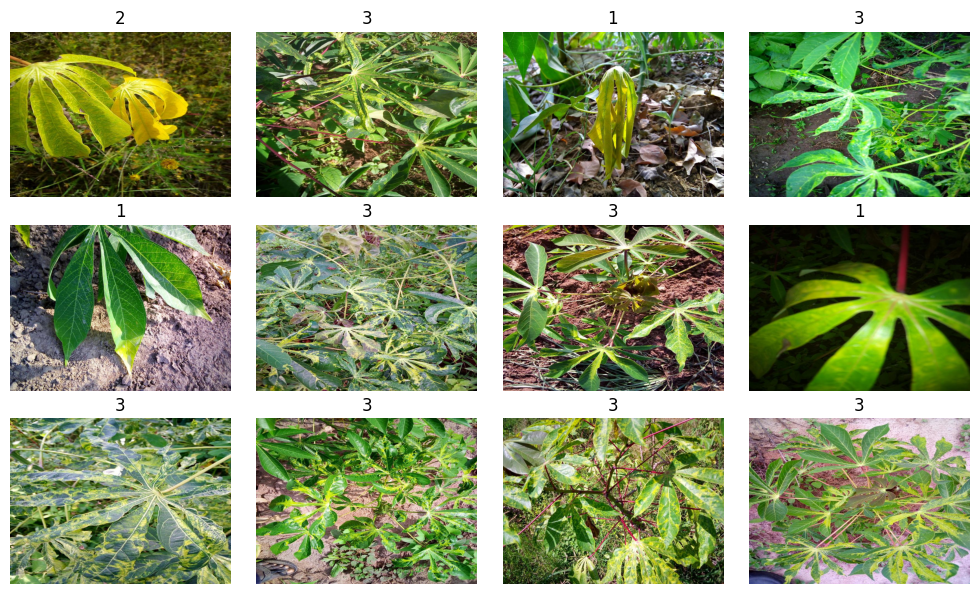

In [13]:
display_image_grid(train_image_paths, true_labels, cols=4)

```json
{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}
```

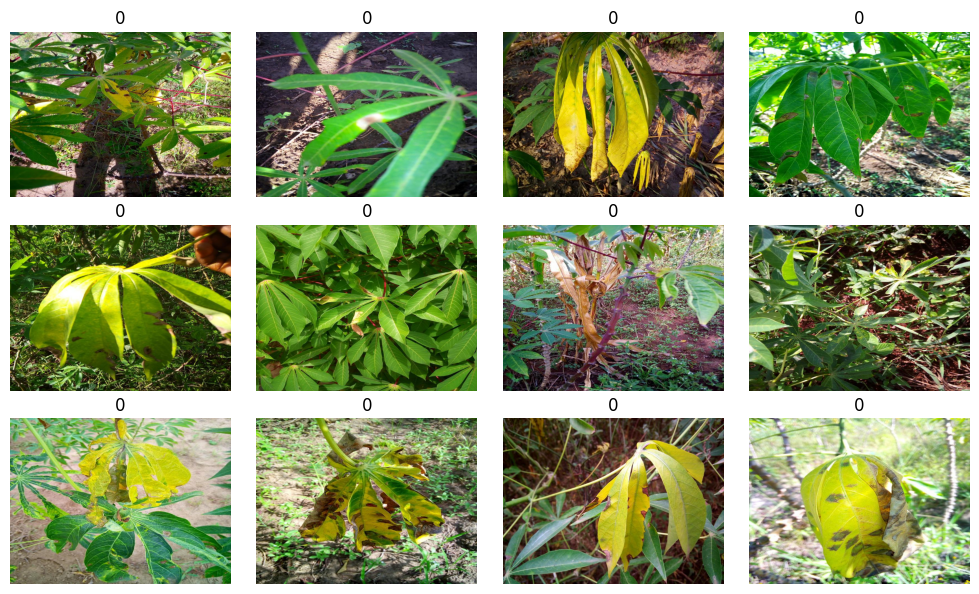

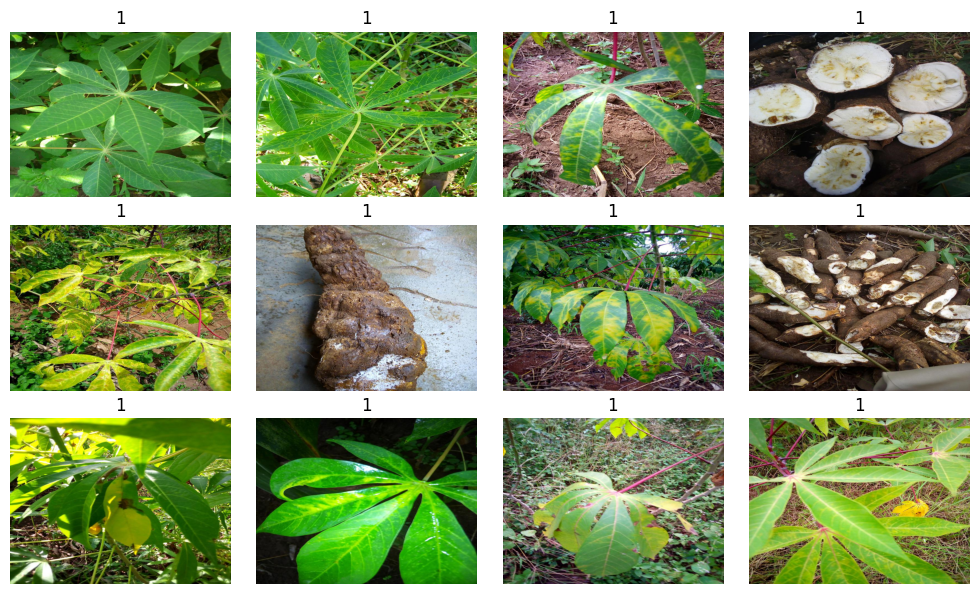

In [14]:
for i in range(2):
    dfx_subset = dfx.query("label == @i").head(N)
    train_image_paths = [image_path / image_id for image_id in dfx_subset.image_id]
    true_labels = dfx_subset.label.values
    
    display_image_grid(train_image_paths, true_labels, cols=4)

### 5) Visualizing augmentations

In [15]:
def display_one_image(images_filepaths, true_labels, predicted_labels=()):
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    for i, image_filepath in enumerate(images_filepaths):
        image = Image.open(image_filepath)
        true_label = true_labels[i]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        if len(predicted_labels) == 0:
            color = "black"
        else:
            color = "green" if true_label == predicted_label else "red"
        ax.imshow(image)
        ax.set_title(predicted_label, color=color)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [16]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [17]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(512, 512),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),  # Reshape to [C, W, H]
    ]
)

In [18]:
df_image = dfx.sample(1, random_state=123)
img_path = [image_path / image_id for image_id in df_image.image_id]
true_label = df_image.label.values


train_dataset = LeafImageDataset(img_path, targets=[1], transform=train_transform)

Original image


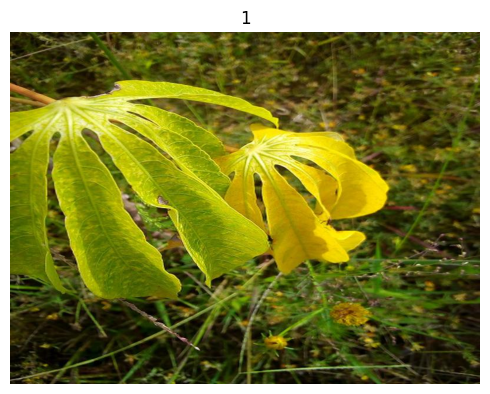

Augmentations


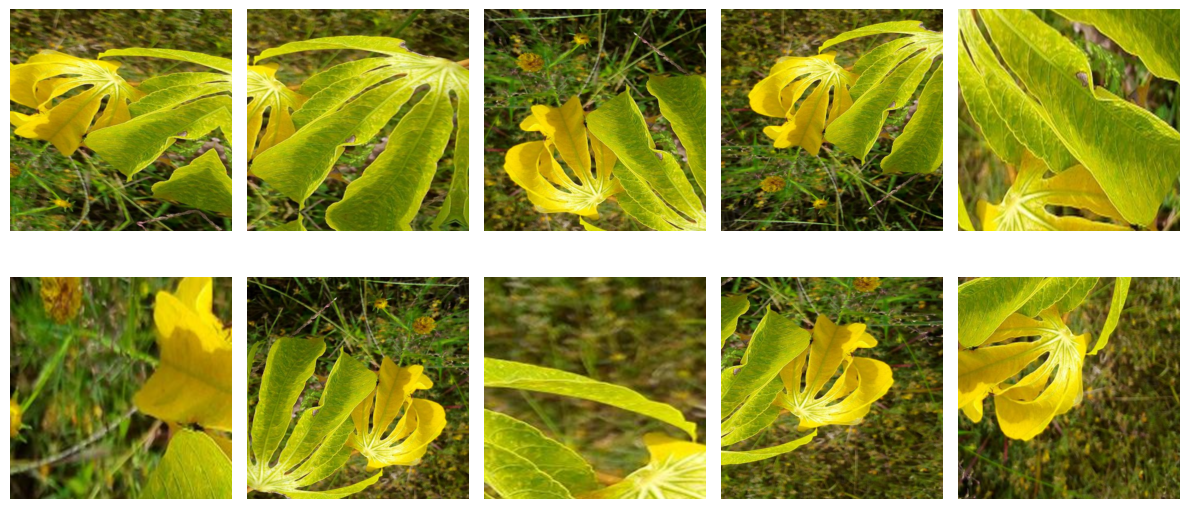

In [19]:
random.seed(123)
print("Original image")
display_one_image(img_path, true_labels=[1])

print("Augmentations")
visualize_augmentations(train_dataset)